# LSTM - Generation

##### Imports

In [16]:
import einops as ein
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from kilroyplot.plot import plt
from torch.distributions.categorical import Categorical
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

## Model

In [17]:
class LSTMSentenceClassifier(nn.Module):
    """LSTM generator. Takes sequence of words, outputs probabilities of next word for each word in the sequence."""

    def __init__(self, vocab_size, embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        y = self.linear(out)
        return F.softmax(y, dim=-1)

## Data

Dataset of next words in a sequence with $0$ as start word and $1$ as end token, for example: $[0, 2, 3, 4, 5, 6] \to [2, 3, 4, 5, 6, 1]$

In [18]:
class NextWordDataset(Dataset):
    def __init__(self, sentences):
        super().__init__()
        self.next_words = [
            (sentence[:-1], sentence[1:]) for sentence in sentences
        ]

    def __getitem__(self, index):
        return self.next_words[index]

    def __len__(self):
        return len(self.next_words)

In [19]:
n_words = 5
special_words = {"start": 0, "end": 1}
n_special_words = len(special_words)
vocab_size = n_words + n_special_words

In [20]:
sentences = torch.cat(
    [
        torch.arange(n_special_words, vocab_size, 1).repeat(1000, 1),
        torch.flip(
            torch.arange(n_special_words, vocab_size, 1).repeat(1000, 1),
            dims=(-1,),
        ),
    ]
)
sentences = torch.cat(
    [
        torch.tensor(special_words["start"]).repeat(len(sentences), 1),
        sentences,
        torch.tensor(special_words["end"]).repeat(len(sentences), 1),
    ],
    dim=-1,
)

In [21]:
dataset = NextWordDataset(sentences)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

## Learning

Simple supervised learning using $x$ and $y$ from datasets

In [22]:
embedding_dim, hidden_dim, out_dim = 2, 4, vocab_size

In [23]:
model = LSTMSentenceClassifier(vocab_size, embedding_dim, hidden_dim, out_dim)

In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [25]:
criterion = nn.CrossEntropyLoss()

In [26]:
epochs = 2000

In [27]:
losses = []
for _ in tqdm(range(epochs)):
    epoch_losses = []
    optimizer.zero_grad()
    for x, y_true in dataloader:
        y_pred = model(x)
        loss = criterion(
            ein.rearrange(y_pred, "b t p -> (b t) p"),
            ein.rearrange(y_true, "b t -> (b t)"),
        )
        epoch_losses.append(loss.item())
        loss.backward()
    optimizer.step()
    losses.append(np.mean(epoch_losses))

100%|██████████| 2000/2000 [00:33<00:00, 59.98it/s]


## Results

Text(0, 0.5, 'loss')

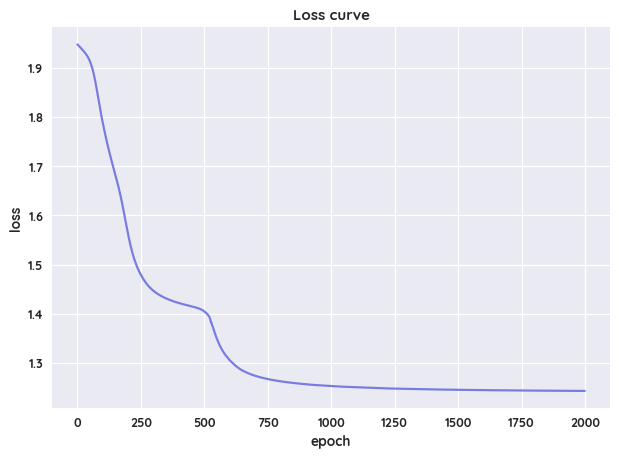

In [28]:
plt.plot(losses)
plt.title("Loss curve")
plt.xlabel("epoch")
plt.ylabel("loss")

##### Generation

In [29]:
def generate_sentence(model, start_word, end_word, max_length=100):
    next_word = start_word
    x = torch.tensor([next_word]).unsqueeze(0)
    i = 0
    while next_word != end_word and i < max_length:
        probs = model(x)[0][-1]
        next_word = Categorical(probs).sample()
        x = torch.cat([x, torch.tensor([next_word]).unsqueeze(-1)], dim=-1)
        i += 1
    return x[0]

In [30]:
[
    generate_sentence(
        model, special_words["start"], special_words["end"]
    ).tolist()
    for _ in range(20)
]

[[0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 6, 5, 4, 3, 2, 1]]